<a href="https://colab.research.google.com/github/pycroscopy/atomai/blob/master/examples/notebooks/rVAE_graphene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring order parameters and dynamic processes in disordered systems via variational autoencoder

*Notebook by Maxim Ziatdinov*

*Email: ziatdinovmax@gmail.com*

In this notebook we explore applications of classical and rotationally-invariant variational autoencoders (VAEs) for mapping an "order parameter" in disordered systems from atomically-resolved experimental movies.

In [1]:
#@title Download dataset
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
157MB [00:00, 278MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
52.4MB [00:00, 60.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
2.45MB [00:00, 158MB/s]


Install AtomAI:

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

Import needed modules:

In [3]:
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import cv2
import atomai as aoi

## Data Inspection and Basic Analysis

Let's load the raw experimental data, semantically-segmented output from a deep neural network, and extracted atomic coordinates. The experimental data is a scanning transmission electron microscopy (STEM) movie showing structural transformations in graphene monolayer under e-beam irradiation. The deep learning predictions were made using a neural network described in our earlier work in *Adv. Func. Mat. 29, 1904480 (2019)*.

In [4]:
STEM_real = np.load('3DStack13-1-exp.npy')
decoded_imgs = np.load('3DStack13-1-dec.npy')
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]

Visual inspection of the loaded data:

Text(0.5, 1.0, 'Atomic coordinates')

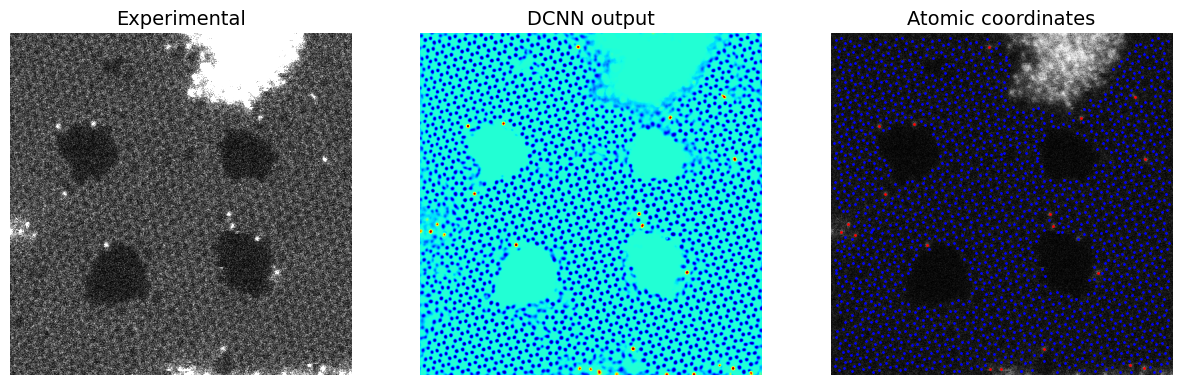

In [5]:
i = 10 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', Interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

Create a set of descriptors, which in this case is a stack of sub-images centered on C (or Si) atoms:

In [6]:
window_size = 24
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, window_size, 0)

We first run a Gaussian mixture model (GMM) on the stack. In GMM, it is assumed that there are $K$ normal distributions parametrized by their mean ($\mu_i$) and covariance ($\Sigma_i$) and that each of extracted sub-images $R_i (x,y)$ is independently drawn from one of these distributions with probability density function given by:

$p(\pmb R_i)= \dfrac{1}{(2\pi)^{0.5n}|\Sigma_{k_i}|^{0.5}}exp(-0.5(\pmb R_i-\mu_k)^T\Sigma^{-1}_{k_i}(\pmb R_i-\mu_k))$.

Here, the number of components is fixed (set by an operator) and the expected minimization algorithm is used to determine the parameters of the mixture. AtomAI allows performing GMM on the stack of images with just one line of code:


GMM components


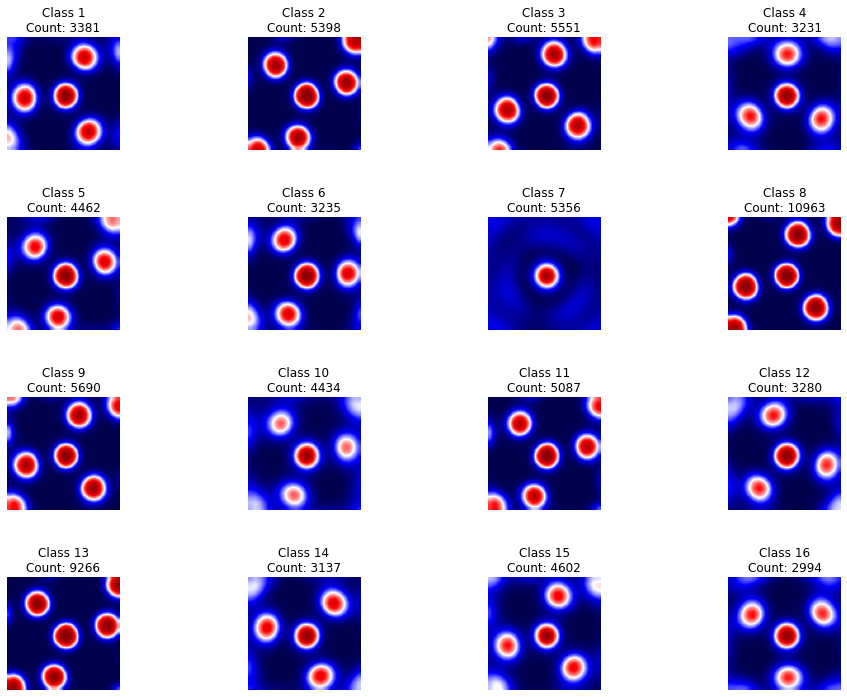

In [7]:
s.gmm(n_components=16, plot_results=True, random_state=42);

Clearly, the GMM failed to correctly identify a meaningful representation of data (the rotated classes represent the same structure, and some of the structures were not unmixed resulting in unphysical GMM components).

## VAE

<img src="https://drive.google.com/uc?export=view&id=1pKGg4UTabAoDJRlohxmFawXSs7wRUK5N" width=400 px><br><br>

Next we try a standard variational autoencoder (VAE). In VAE, one assumes that each point in the dataset is generated by a local random variable in a complex, non-linear way. The encoder part of a VAE is used to find good values for the latent random variables such that they are true to our (fixed) prior beliefs and true to the data. The priors in a VAE are the type of distribution for the latent variables (usually a Gaussian distribution) and the parameters of this distribution. The decoder part of a VAE is used to make a prediction for the data based on a sample from this distribution. The model parameters (weights and biases) are learned by maximizing the evidence lower bound (ELBO), which consists of the Kullback-Leibler divergence term $D_{KL}$ and the expected likelihood (reconstruction error):

$ELBO = -RE - D_{KL}(q(z|x)||\mathcal{N}(0, I))$.

Prepare training data:

In [8]:
imstack = s.imgstack[..., 0] # will be used as training/test data
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    imstack, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(68056, 24, 24) (12011, 24, 24)


Train a VAE model:

In [9]:
# Ititialize model
in_dim = (window_size, window_size)
vae = aoi.models.VAE(in_dim)
# Train
vae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200, batch_size=200)

Epoch: 1/200, Training loss: 17.2779, Test loss: 11.8616
Epoch: 2/200, Training loss: 11.6368, Test loss: 11.5626
Epoch: 3/200, Training loss: 11.4334, Test loss: 11.4040
Epoch: 4/200, Training loss: 11.2756, Test loss: 11.2337
Epoch: 5/200, Training loss: 11.0547, Test loss: 10.9095
Epoch: 6/200, Training loss: 10.6764, Test loss: 10.5163
Epoch: 7/200, Training loss: 10.3529, Test loss: 10.3149
Epoch: 8/200, Training loss: 10.2310, Test loss: 10.2033
Epoch: 9/200, Training loss: 10.1459, Test loss: 10.1609
Epoch: 10/200, Training loss: 10.0915, Test loss: 10.1004
Epoch: 11/200, Training loss: 10.0404, Test loss: 10.0401
Epoch: 12/200, Training loss: 10.0029, Test loss: 10.0108
Epoch: 13/200, Training loss: 9.9555, Test loss: 9.9842
Epoch: 14/200, Training loss: 9.9259, Test loss: 9.9527
Epoch: 15/200, Training loss: 9.9021, Test loss: 9.8981
Epoch: 16/200, Training loss: 9.8754, Test loss: 9.8847
Epoch: 17/200, Training loss: 9.8485, Test loss: 9.8554
Epoch: 18/200, Training loss: 9.8

Visualize the learned manifold:

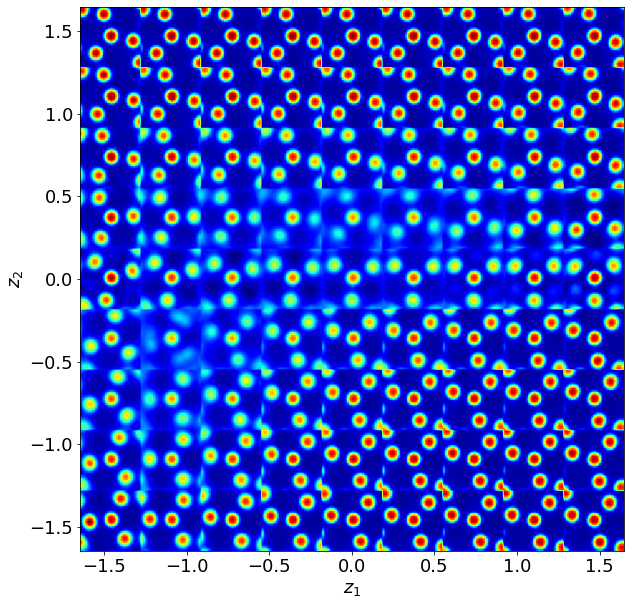

In [55]:
vae.manifold2d(cmap="jet");

Here, the descriptors on the left and right correspond to two graphene sublattices, while those in the middle encode lateral shifts, defects, and rotations in a convoluted fashion. So, clearly, the VAE didn't do a very good job.


## *r*VAE

To tackle the issue with rotations, we utilize the rotationally invariant extension of VAE (rVAE). The rVAE is based on the concept of [spatial decoder](https://arxiv.org/abs/1909.11663) introduced by Bepler *et al.* and represents a special class of VAEs where three of the latent variables are rotation and x- and y-offsets, complemented by classical latent variables associated with image content. Thus, rVAE adds rotational and (in this case) offset invariance to the analysis workflow. In other words, it is expected to recognize the images even if they are shifted and rotated with respect to each other. The ELBO objective in the case of rVAE is:

$ELBO = -RE - D_{KL}(q(z|x)||\mathcal{N}(0, I)) - D_{KL}(q(\gamma|x)||\mathcal{N}(0, s^2_\gamma))$,

where the first term is again the reconstruction error, the second and third terms are the Kullback-Leibler (KL) terms associated with image content and rotation, repsectively, $z$ is a latent variable associated with image content, $\gamma$ is a latent angle variable, and $s_\gamma$ is a “rotational prior”. Here, we will use the encoder and decoder both consisting of 2 fully-connected layers with 128 neurons in each layer activated by *tanh()*. The latent layer had 3 neurons for absorbing arbitrary rotations and translations of images content, whereas the remaining 2 neurons in the latent layer were used for disentangling the image content.

Note that rVAE also supports class-conditioned training (if there are labels available) and skip connections for avoiding posterior collapse in some situations. One can also set a custom encoder (e.g. encoder with gropu-equiavariant convolutional layers). See AtomAI's  documentation for details.

In [11]:
# Ititialize model
in_dim = (window_size, window_size)
rvae = aoi.models.rVAE(in_dim)
# Train
rvae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200, batch_size=200)

Epoch: 1/200, Training loss: 26.1272, Test loss: 23.9173
Epoch: 2/200, Training loss: 23.8803, Test loss: 23.7319
Epoch: 3/200, Training loss: 23.1931, Test loss: 22.2671
Epoch: 4/200, Training loss: 21.7676, Test loss: 21.2520
Epoch: 5/200, Training loss: 20.4953, Test loss: 19.6524
Epoch: 6/200, Training loss: 19.1225, Test loss: 18.5702
Epoch: 7/200, Training loss: 18.2197, Test loss: 17.8806
Epoch: 8/200, Training loss: 17.5676, Test loss: 17.1938
Epoch: 9/200, Training loss: 16.7368, Test loss: 16.2236
Epoch: 10/200, Training loss: 15.6014, Test loss: 14.9938
Epoch: 11/200, Training loss: 14.4289, Test loss: 13.9831
Epoch: 12/200, Training loss: 13.5981, Test loss: 13.2731
Epoch: 13/200, Training loss: 12.9364, Test loss: 12.6805
Epoch: 14/200, Training loss: 12.3331, Test loss: 12.1388
Epoch: 15/200, Training loss: 11.8960, Test loss: 11.7865
Epoch: 16/200, Training loss: 11.6330, Test loss: 11.5937
Epoch: 17/200, Training loss: 11.4286, Test loss: 11.3919
Epoch: 18/200, Training

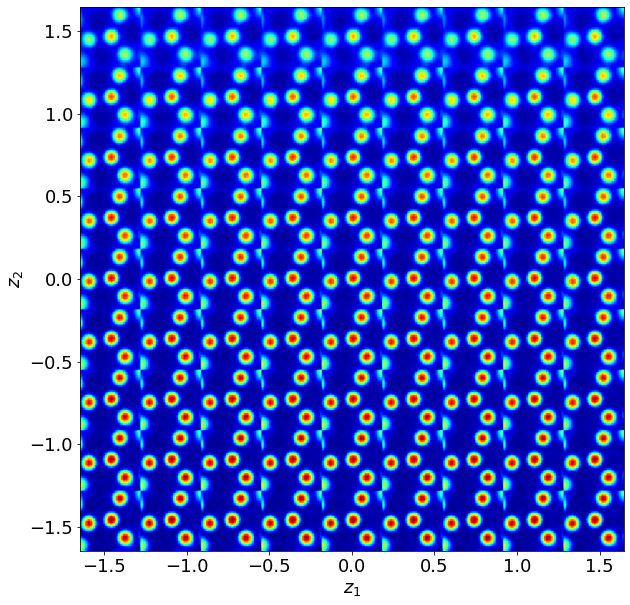

In [56]:
rvae.manifold2d(cmap="jet");

Since rotational variation is effectively removed from elementary descriptors, remaining variations within data can be described much more efficiently than with the regular VAE.

Now let's encode the entire image stack (our movie). Here the first latent variable is associated with rotation, the second and third ones are associated with translations in *x* and *y* directions, and the latent variables starting from the third one correspond to images content.

In [13]:
z_mean, z_sd = rvae.encode(imstack)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

Plot distributions of "structural" latent variables (angle and translations):

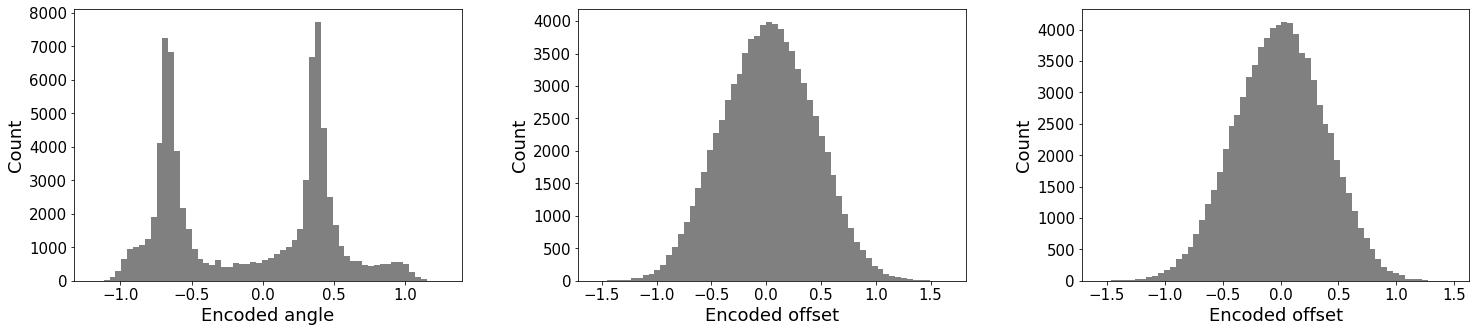

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

Plot evolution of the encoded latent variables:

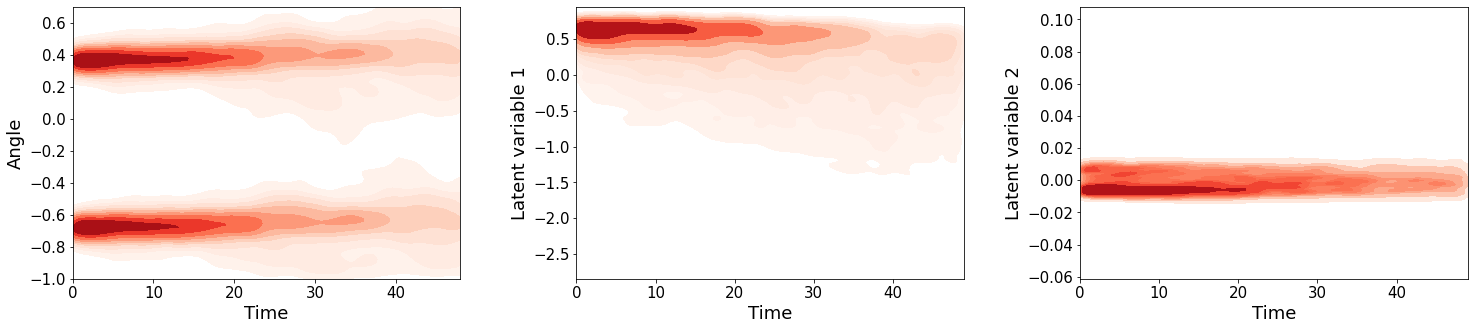

In [54]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].set_xlim(0, 48)
ax[0].set_ylim(-1., 0.7)
ax[0].set_ylabel("Angle", fontsize=18)
ax[1].set_ylabel("Latent variable 1", fontsize=18)
ax[2].set_ylabel("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.set_xlabel("Time", fontsize=18)
    _ax.tick_params(labelsize=15)
sns.kdeplot(frames_all, y=z1,
            cmap="Reds", shade=True, ax=ax[0],
            thresh=0.15,  cut=0, bw_method=.075)
sns.kdeplot(frames_all, y=z3[:, 0],
            cmap="Reds", shade=True, ax=ax[1],
            thresh=0.15,  cut=0, bw_method=.075)
sns.kdeplot(frames_all, y=z3[:, 1],
            cmap="Reds", shade=True, ax=ax[2],
            thresh=0.15,  cut=0, bw_method=.075)
plt.subplots_adjust(wspace=.3)
plt.show()

Finally we map the encoded values associated with the subimages (encoded angle and latent variables associated with images content) onto the original movie frames:

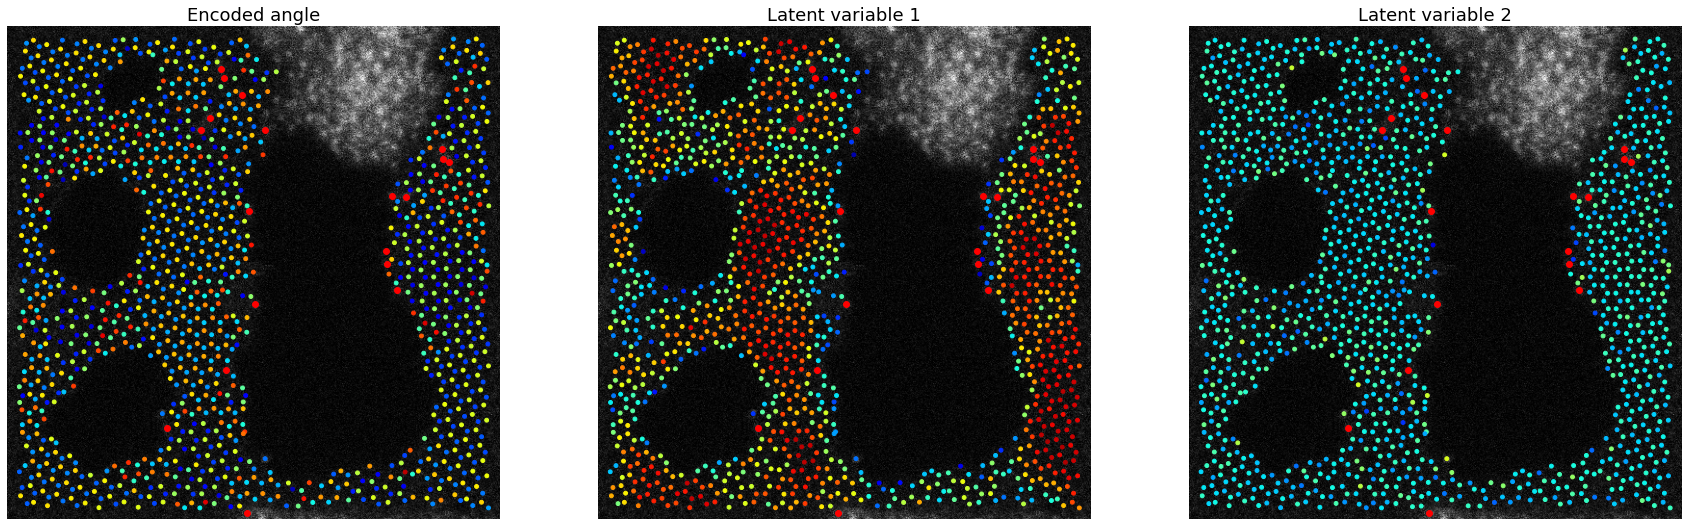

In [16]:
frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()

Here, the color scale of each atomic unit is set according
to the value of the corresponding latent variable for angle (first image) and first two latent variable associated with images content (second and third images). The angle variable shows clear contrast for the two structurally unique sublattice positions in the graphene lattice, giving rise to the checkerboard-like pattern. Small angle boundaries and the rotation between graphene fragments are clearly visible. At the same time, the behavior of the first latent variable corresponding to the content of sub-images clearly shows that it adopts maximum value in the well-ordered regions and is reduced at the edges and in regions with high defect density, allowing for its interpretation as local crystallinity. 